In [1]:
import torch

save_name = "qwen-1.5b"

save_name_to_idx_map = {
    "qwen-1.5b": 0,
    "qwen-7b": 1,
    "qwen-14b": 2,
}

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}

weight_path = f"../checkpoints/version_{save_name_to_idx_map[save_name]}/{save_name}_13.pt"
weights = torch.load(weight_path, map_location="cpu")
print(weights.keys())

/tmp/ipykernel_4116926/3086551925.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path, map_location="cpu")


odict_keys(['W_enc', 'W_dec', 'b_enc', 'b_dec'])


In [2]:
base_dec = weights["W_dec"][:, 0, :]
reasoning_dec = weights["W_dec"][:, 1, :]
print(base_dec.shape, reasoning_dec.shape)

torch.Size([32768, 1536]) torch.Size([32768, 1536])


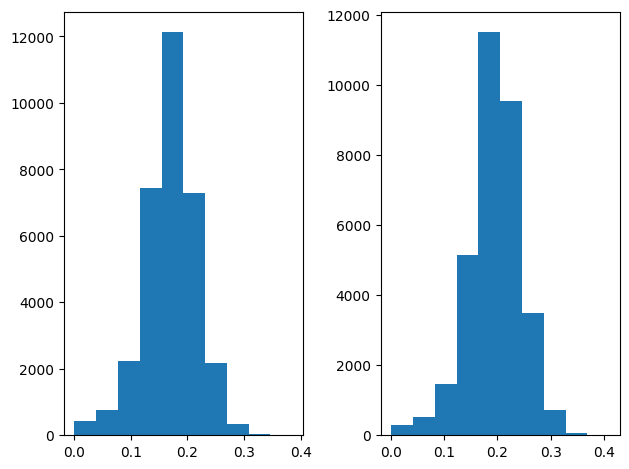

In [20]:
base_norms = torch.norm(base_dec, dim=1)
reasoning_norms = torch.norm(reasoning_dec, dim=1)

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.hist(base_norms.float())
plt.subplot(1,2,2)
plt.hist(reasoning_norms.float())

plt.tight_layout()

(array([2.4000e+01, 4.6000e+01, 7.4000e+01, 1.8400e+02, 2.5920e+03,
        2.8309e+04, 1.1410e+03, 1.9100e+02, 1.2000e+02, 8.7000e+01]),
 array([0.00810501, 0.106071  , 0.204037  , 0.302003  , 0.39996898,
        0.49793497, 0.59590101, 0.69386697, 0.79183292, 0.889799  ,
        0.98776489]),
 <BarContainer object of 10 artists>)

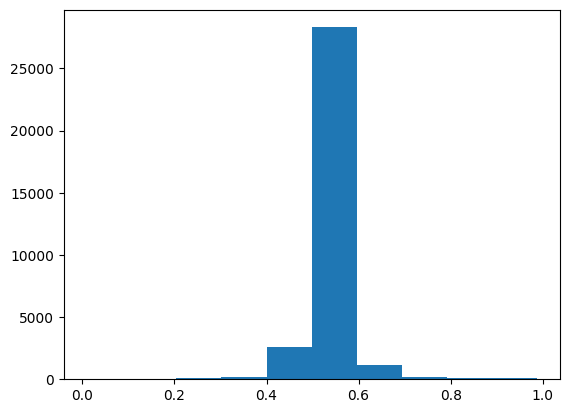

In [21]:
relative_norms = reasoning_norms.float() / base_norms.float()
normalized_relative_norms = relative_norms / (1 + relative_norms)
plt.figure()
plt.hist(normalized_relative_norms)

In [8]:
torch.topk(normalized_relative_norms, 10)[1]

tensor([18078, 30677, 13930,  8306, 31608,  5750, 18466, 26970, 21291, 22943])

In [9]:
feat_idx = torch.argmax(normalized_relative_norms)
print(feat_idx)

tensor(18078)


In [10]:
from crosscoder_diff.utils import load_reasoning_tokens

all_tokens = load_reasoning_tokens()


/om/user/dbaek/.conda/envs/crosscoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Loading reasoning tokens from disk


/weka/scratch/weka/tegmark/dbaek/deepseek-diff/crosscoder_diff/utils.py:202: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [2]:
from transformer_lens import HookedTransformer, ActivationCache
import torch
import os
os.environ['HF_HOME'] = '/om2/user/dbaek/.cache/'

device = "cuda" if torch.cuda.is_available() else "cpu"

save_name = "qwen-1.5b"

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(name_to_model_map[save_name][0])


base_model = HookedTransformer.from_pretrained(
    name_to_model_map[save_name][0],
    device=device, 
)

chat_model = HookedTransformer.from_pretrained(
    name_to_model_map[save_name][1],
    device=device, 
)
hook_point = f"blocks.{base_model.cfg.n_layers // 2}.hook_resid_pre"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model Qwen/Qwen2.5-Math-1.5B into HookedTransformer


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


In [3]:
wait_token_ids = set(
    tokenizer.encode("Therefore", add_special_tokens=False) +
    tokenizer.encode("Thus", add_special_tokens=False)
)
print("Wait token IDs:", wait_token_ids)

Wait token IDs: {14190, 3783}


In [12]:
print(tokenizer.encode("Alternatively", add_special_tokens=False))

[92014]


In [16]:
target_name = "wait"

target_token_map = {
    "wait" : [" wait", "Wait"],
    "deductive": ["Therefore", "Thus"],
    "alternative": ["Alternatively"],
    "contrast": ["However", "But"]
}
wait_token_ids = set()
for target_token in target_token_map[target_name]:
    token_ids = tokenizer.encode(target_token, add_special_tokens=False)
    wait_token_ids.update(token_ids)

print("Wait token IDs:", wait_token_ids)

[3783]
[14190]
Wait token IDs: {14190, 3783}


In [9]:
weight_path = "./checkpoints/version_0/qwen-1.5b_0.pt"
weights = torch.load(weight_path)


import torch
import einops


for feat_idx in [18078, 30677, 13930,  8306, 31608,  5750, 18466, 26970, 21291, 22943]:
    torch.cuda.empty_cache()
    # List to store the top 10 activations per sequence.
    # Each entry is a tuple: (activation_value, batch_index, token_index)
    results = []

    # Process each sequence (i.e. each row) individually.
    for batch_idx, tokens in enumerate(all_tokens[:100]):
        # If tokens is 1D (shape [seq_length]), add a batch dimension.
        if tokens.ndim == 1:
            tokens = tokens.unsqueeze(0)  # Now shape becomes [1, seq_length]
        
        # Run the models to obtain cached activations at the hook point.
        _, cache_A = base_model.run_with_cache(tokens, names_filter=hook_point)
        _, cache_B = chat_model.run_with_cache(tokens, names_filter=hook_point)
        
        # Stack the two models’ activations along a new dimension "n_models".
        # Assume each cache entry has shape: [batch, seq_len, d_model]  
        # → stacked shape: [batch, n_models, seq_len, d_model]
        acts = torch.stack([cache_A[hook_point], cache_B[hook_point]], dim=1)
        
        # Drop the BOS token (position 0) along the sequence dimension.
        # New shape becomes: [batch, n_models, seq_len-1, d_model]
        acts = acts[:, :, 1:, :]
        
        # Rearrange so that each token becomes an individual “batch” element.
        # Now shape: [ (batch * (seq_len-1)), n_models, d_model ]
        acts = einops.rearrange(acts, "batch n_models seq_len d_model -> (batch seq_len) n_models d_model")
        acts = acts.to(device)
        
        # Compute the encoded representation using the weight matrix.
        # The einsum combines the activations from the n_models dimension.
        # Resulting shape: [ (seq_len-1), d_hidden ]
        x_enc = einops.einsum(
            acts,
            weights["W_enc"],
            "batch n_models d_model, n_models d_model d_hidden -> batch d_hidden"
        )
        
        # Extract the activation values for the feature of interest.
        # feat_values has shape: [ (seq_len-1) ], where each index corresponds to token index (j+1)
        # in the original sequence (since BOS was dropped).
        feat_values = x_enc[:, feat_idx]
        
        # Instead of storing all token activations from this sequence,
        # use torch.topk to keep only the top 10 activations.
        k = min(10, feat_values.size(0))  # In case the sequence is very short.
        row_topk_values, row_topk_indices = torch.topk(feat_values, k=k)
        
        # Save these top activations along with their positions.
        # (Add 1 to token indices to map back to the original tokens, because BOS was dropped.)
        for token_idx_offset, activation in zip(row_topk_indices.tolist(), row_topk_values.tolist()):
            results.append((activation, batch_idx, token_idx_offset + 1))
        
        if batch_idx % 20 == 0:
            print(batch_idx)

    # After processing all sequences, `results` contains at most 10 entries per row.
    # Now sort them in descending order by activation to obtain the overall top 10.
    top10 = sorted(results, key=lambda x: x[0], reverse=True)[:10]

    # Print the overall top 10 token positions with context from the original tokens.
    for rank, (activation, batch_idx, token_idx) in enumerate(top10, start=1):
        # Define a context window, e.g., 20 tokens before the target token.
        context_start = max(token_idx - 100, 0)
        context_tokens = all_tokens[batch_idx, context_start: token_idx + 1]
        decoded_context = tokenizer.decode(context_tokens.tolist())
        
        print(f"Rank {rank}: Batch {batch_idx}, Token index {token_idx}, Activation {activation:.4f}\n"
            f"Context: {decoded_context}\n")

/tmp/ipykernel_2272802/3897810721.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Rank 1: Batch 46, Token index 170, Activation 5.1221
Context:  the expansion is carried out freely, it is simultaneously both isothermal as well as adiabatic



Rank 2: Batch 18, Token index 310, Activation 5.0475
Context: I}|$ (in SI units).
<think>Let's break down the problem and think step by

Rank 3: Batch 96, Token index 99, Activation 4.8003
Context:  $\overline{AD}$ makes an angle of $45^\circ$ with side $\overline

Rank 4: Batch 28, Token index 345, Activation 4.3492
Context:  $3541 \mathrm{~km}$ to Earth's surface. The distance from the center

Rank 5: Batch 34, Token index 400, Activation 4.1262
Context: 5$
$b_{1} = 2013$
$b_{2} = 20

Rank 6: Batch 51, Token index 38, Activation 4.1128
Conte

KeyboardInterrupt: 